# 1. Import Packages and Spark Database

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import tensorflow as tf

import findspark
findspark.init()

# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("winequality-red").getOrCreate()

from pyspark import SparkFiles
path = "winequality-red.csv"
spark.sparkContext.addFile(path)
df = spark.read.csv(SparkFiles.get("winequality-red.csv"), sep=",", header=True)

# Show DataFrame
df.head()

Row(fixed acidity='7.4', volatile acidity='0.7', citric acid='0.0', residual sugar='1.9', chlorides='0.076', free sulfur dioxide='11.0', total sulfur dioxide='34.0', density='0.9978', pH='3.51', sulphates='0.56', alcohol='9.4', quality='5')

In [226]:
#Convert PySpark dataset to Pandas
data=df.toPandas()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6
4,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Data Clean-up

In [227]:
# Remove rows with missing values
data.dropna(inplace=True)

In [228]:
# Check for null values again after cleanup
print("Null values after cleanup:")
print(data.isnull().sum())

Null values after cleanup:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [229]:
#show number of rolls and detail of dataframe
data.info

<bound method DataFrame.info of      fixed acidity volatile acidity citric acid residual sugar chlorides  \
0              7.4              0.7         0.0            1.9     0.076   
1              7.8             0.88         0.0            2.6     0.098   
2              7.8             0.76        0.04            2.3     0.092   
3             11.2             0.28        0.56            1.9     0.075   
4              7.4              0.7         0.0            1.9     0.076   
...            ...              ...         ...            ...       ...   
1594           6.2              0.6        0.08            2.0      0.09   
1595           5.9             0.55         0.1            2.2     0.062   
1596           6.3             0.51        0.13            2.3     0.076   
1597           5.9            0.645        0.12            2.0     0.075   
1598           6.0             0.31        0.47            3.6     0.067   

     free sulfur dioxide total sulfur dioxide          

## 2.1 Check bias and classifications

In [230]:
# Assuming 'data' is your DataFrame
quality_counts = data['quality'].value_counts().sort_index(ascending=False)
print(quality_counts)

quality
8     18
7    199
6    638
5    681
4     53
3     10
Name: count, dtype: int64


In [231]:
# Convert 'quality' column to numeric
data['quality'] = pd.to_numeric(data['quality'], errors='coerce')

# Create clasiification Good (6 and above) and Bad (6 and below)
bins = [0, 5.9, 10]  # 5.9 to include 6 in the "6 and above" category
labels = ['below 6', '6 and above']

# Bin the 'quality' column
quality_categories = pd.cut(data['quality'], bins=bins, labels=labels, include_lowest=True)

# Count occurrences of each category
quality_counts = quality_categories.value_counts()

# Calculate percentages
quality_percentages = ((quality_counts / quality_counts.sum())* 100).round(2)

quality_percentages_df = pd.DataFrame(quality_percentages)
quality_percentages_df

,count
quality,
6 and above,53.47
below 6,46.53


## Check correlation of all features

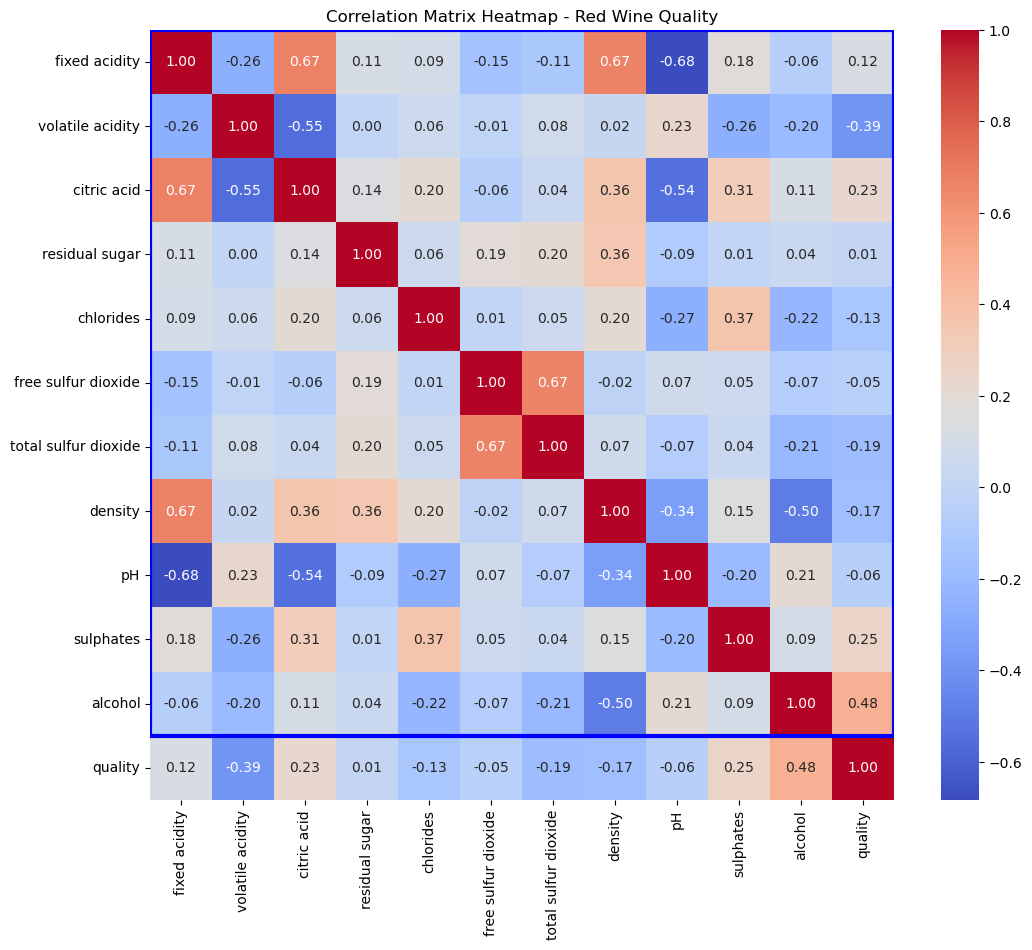

In [232]:
# Compute the correlation matrix 
# Calculate correlation matrix
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add title
plt.title('Correlation Matrix Heatmap - Red Wine Quality')

# Highlight correlations with 'Potability'
highlight = correlation_matrix['quality'].sort_values(ascending=False)
highlight = highlight.drop('quality')  # Remove self-correlation
highlight_cols = highlight.index.tolist()
heatmap.add_patch(plt.Rectangle((0, 0), len(correlation_matrix), len(highlight_cols), fill=False, edgecolor='blue', lw=3))

# Show plot
plt.show()

# 3. Normalisation and Standardization 

In [233]:
# Separate features and target variable
X = data.drop('quality', axis=1)
y = data['quality']

In [234]:
# Normalize or scale the features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [235]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)


# 4. Machine Learning Model Attempts

## 4.1 Random Forest Model

In [236]:
# Initialize and fit the Random Forest model
rf_model = RandomForestClassifier(random_state=50)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=50)

In [237]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
10,alcohol,0.150609
9,sulphates,0.115033
1,volatile acidity,0.102129
6,total sulfur dioxide,0.101270
7,density,0.091951
0,fixed acidity,0.080192
4,chlorides,0.079843
8,pH,0.076647
2,citric acid,0.070201
3,residual sugar,0.067891


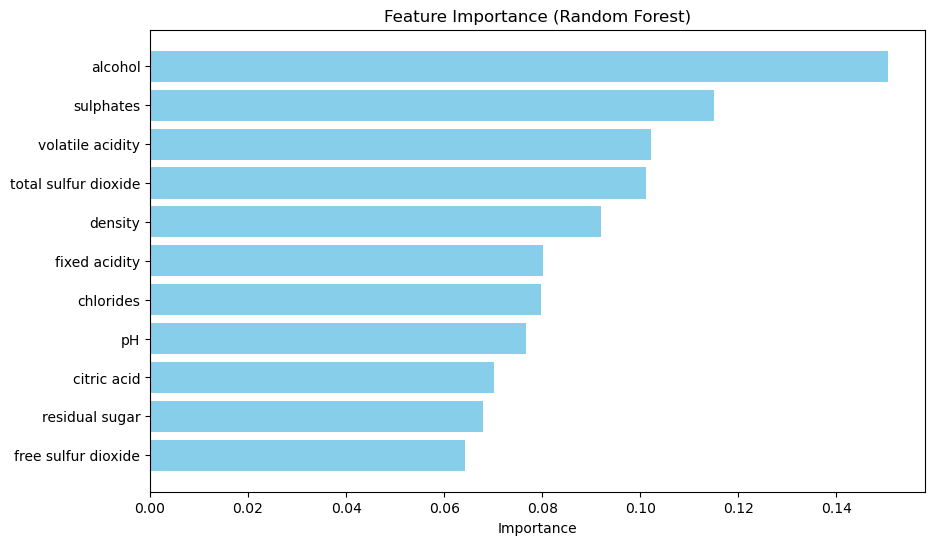

In [238]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to display features with the most important at the top
plt.show()

In [239]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.72


## 4.1.1 Optimization : Hyper Parameter Tuning using GridSearchCV

In [240]:
X = data.drop(['free sulfur dioxide', 'quality'], axis=1)
y = data['quality']
# Categorize 'quality' into bins
# Treat wine quality >= 6 as 'good' (1) and < 6 as 'not good' (0)
threshold = 6
y_binary = (y >= threshold).astype(int) # 1 for good, 0 for not good

# Check the balance of the newly defined binary classes in 'y_binary'
class_balance_binary = y_binary.value_counts(normalize=True)
print(class_balance_binary)



quality
1    0.534709
0    0.465291
Name: proportion, dtype: float64


In [241]:
# Normailise the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [242]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=50)


In [243]:
# Define the parameter grid
param_grid = {
   'n_estimators': [100, 200],
   'max_depth': [None, 10, 20],
   'min_samples_split': [2, 5],
   'min_samples_leaf': [1, 2],
   'class_weight': ['balanced']
}

In [244]:
# Initialize the model
rf = RandomForestClassifier(random_state=50)

In [245]:
# Initialize Grid Search with balanced_accuracy as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)

In [246]:
# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=50), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [40]:
# Best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8010051169749932


In [41]:
# Predict the labels for the test set
y_pred = grid_search.predict(X_test)

In [42]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")
# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8063
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       178
           1       0.76      0.82      0.79       142

    accuracy                           0.81       320
   macro avg       0.80      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



## 4.2 Linear regression vs. logistic regression

## 4.2.1 Linear Regression

In [43]:
X = data.drop(['quality'], axis=1)
y = data['quality']


In [44]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Assuming y_train and y_test are continuous variables for a regression problem
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Print R-squared
print(f"R-squared: {r_squared:.4f}")

R-squared: 0.4032


## 4.2.2 Optimization: Utilize categorization Good (6 and above) and Bad (below 6)

In [47]:
X = data.drop(['quality'], axis=1)
y = data['quality']

In [48]:
# Convert quality into categories (assuming good: 6-8, bad: below 6)
threshold = 6
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Feature scaling (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7406
              precision    recall  f1-score   support

           0       0.69      0.74      0.72       141
           1       0.79      0.74      0.76       179

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



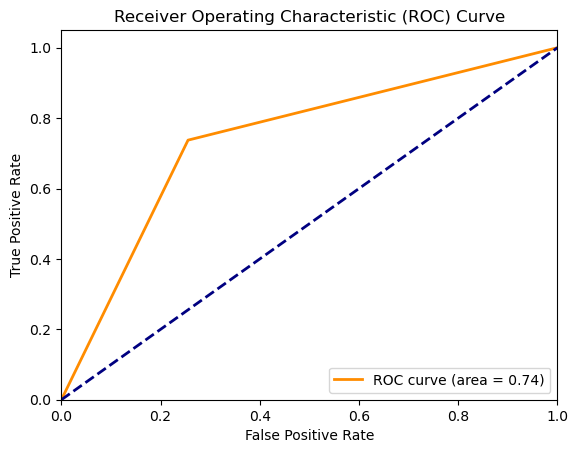

In [49]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

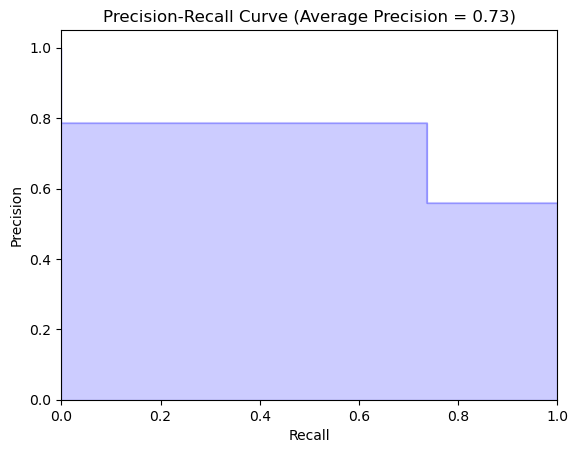

In [50]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

## 4.3 Decision Tree

### 4.3.1 Optimization: with categorization (Remove the least important feature)

In [51]:
X = data.drop(['free sulfur dioxide','quality'], axis=1)
y = data['quality']

# Convert quality into categories (assuming good: 6-8, bad: below 6)
threshold = 6
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7531
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       141
           1       0.79      0.76      0.77       179

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



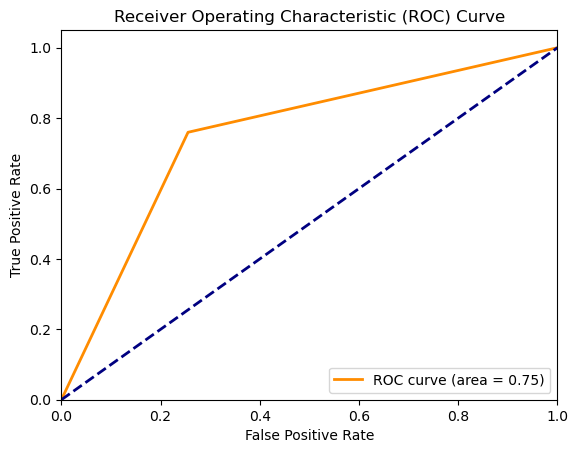

In [52]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

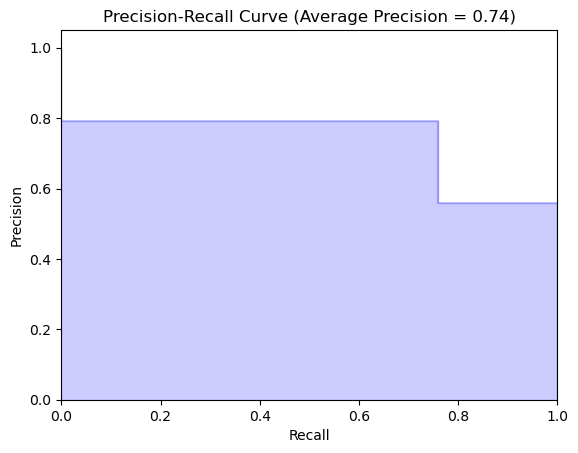

In [53]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

### 4.3.2 Optimization: Hyperparameter Tuning

In [54]:
# Hyperparameter Tuning for Decision Tree
param_grid = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]},
             scoring='f1')

In [55]:
# Best parameters and re-evaluation
print(f"Best Parameters: {grid_search.best_params_}")
best_tree_clf = grid_search.best_estimator_
y_pred_best_tree = best_tree_clf.predict(X_test)
print("Optimized Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_best_tree))

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       141
           1       0.78      0.73      0.75       179

    accuracy                           0.73       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.73      0.73      0.73       320



### 4.3.3 Optimisation: Narrow classification good (7 and above) and Bad (less than 7)

In [57]:
X = data.drop(['free sulfur dioxide','quality'], axis=1)
y = data['quality']

# Convert quality into categories (assuming good: 7-10, bad: below 7)
threshold = 7
y_binary = (y >= threshold).astype(int)  # 1 for good, 0 for bad

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8719


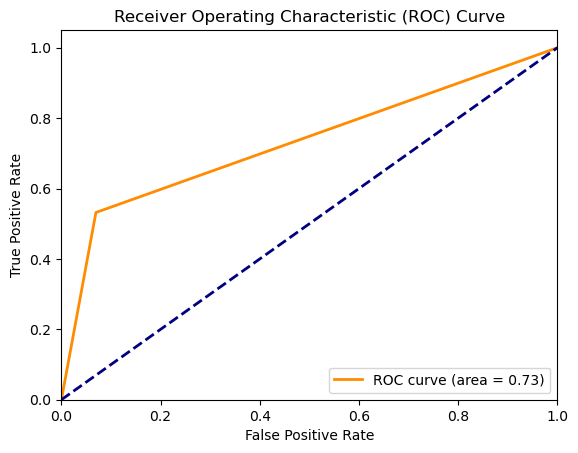

In [58]:
#Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

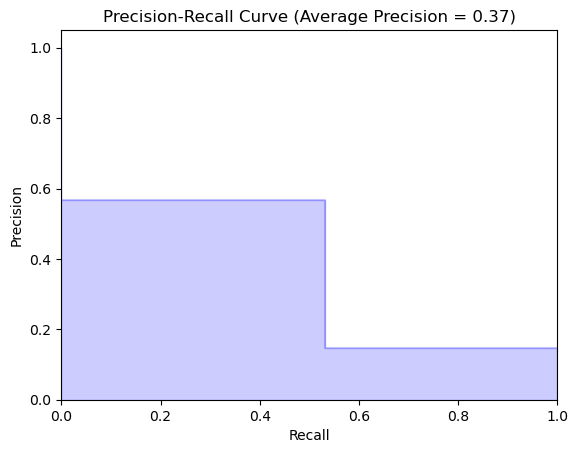

In [59]:
# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_pred)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (Average Precision = {0:0.2f})'.format(average_precision))
plt.show()

## 4.4 Tensorflow neural network model
#### Drop highly corelated columns pH, fixed acidity and citric acid, retain density as it has higher importance

In [214]:
nn_df = data.drop(['citric acid', 'fixed acidity', 'pH', 'free sulfur dioxide'], axis =1)
# round off density to 3 digits as some values are too long
nn_df['density'] = nn_df['density'].astype('float64').apply(lambda x: round(x, 3))
nn_df.head()

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,0.7,1.9,0.076,34.0,0.998,0.56,9.4,5
1,0.88,2.6,0.098,67.0,0.997,0.68,9.8,5
2,0.76,2.3,0.092,54.0,0.997,0.65,9.8,5
3,0.28,1.9,0.075,60.0,0.998,0.58,9.8,6
4,0.7,1.9,0.076,34.0,0.998,0.56,9.4,5


In [215]:
# Separate features and target variable
X = nn_df.drop('quality', axis=1)
y = nn_df['quality']
X

,volatile acidity,residual sugar,chlorides,total sulfur dioxide,density,sulphates,alcohol
0,0.7,1.9,0.076,34.0,0.998,0.56,9.4
1,0.88,2.6,0.098,67.0,0.997,0.68,9.8
2,0.76,2.3,0.092,54.0,0.997,0.65,9.8
3,0.28,1.9,0.075,60.0,0.998,0.58,9.8
4,0.7,1.9,0.076,34.0,0.998,0.56,9.4
...,...,...,...,...,...,...,...
1594,0.6,2.0,0.09,44.0,0.995,0.58,10.5
1595,0.55,2.2,0.062,51.0,0.995,0.76,11.2
1596,0.51,2.3,0.076,40.0,0.996,0.75,11.0
1597,0.645,2.0,0.075,44.0,0.995,0.71,10.2


In [216]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [217]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [218]:
import sklearn as skl

# Create a StandardScaler instances
scaler = skl.preprocessing.StandardScaler()

# Fit the StandardScaler
scaler.fit(X_train)

# Scale the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [219]:
X_train_scaled

array([[-0.23260309, -0.24631811, -0.1107459 , ...,  1.75371689,
        -1.3131938 , -1.15257747],
       [ 0.37802632, -0.24631811,  0.19329395, ...,  1.21122294,
        -0.97064635, -1.24703683],
       [ 0.32251456, -0.31717594,  0.05140868, ..., -0.95875286,
        -0.62809889,  1.01998773],
       ...,
       [ 0.48904985,  0.10797101, -0.23236184, ...,  0.12623504,
        -0.68519014, -0.8691994 ],
       [-1.84244427, -0.60060724, -0.69855628, ..., -0.95875286,
         0.79918216,  1.39782516],
       [-1.34283839, -0.60060724, -0.51613237, ..., -2.58623472,
        -0.68519014,  2.90917487]])

In [220]:
y_train

582     5
626     5
1030    7
620     5
490     6
       ..
1130    6
1294    6
860     5
1459    7
1126    6
Name: quality, Length: 1199, dtype: int64

In [221]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])

def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_dim=number_input_features),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [222]:
nn = build_model()

C:\Users\Folio\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [223]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=200)

Epoch 1/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 30.4094
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -11.8936
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -36.4510
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -52.4201
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -61.7785
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -68.0187
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -70.5991
Epoch 8/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -71.1173
Epoch 9/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -72.5159
Epoch 10/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -72.9326
Epoch 11/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.163

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -73.7320
Epoch 67/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -73.6648
Epoch 68/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: -73.7356
Epoch 69/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -73.9879
Epoch 70/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -74.2952
Epoch 71/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -73.5998
Epoch 72/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -73.9257
Epoch 73/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: -73.9653
Epoch 74/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: -73.8926
Epoch 75/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: -73.6402
Epoch 76/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: -73.6518
E

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.5700
Epoch 195/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.5728
Epoch 196/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.7842
Epoch 197/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.8417
Epoch 198/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.0306
Epoch 199/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.8269
Epoch 200/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -73.3755


In [195]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

13/13 - 0s - 15ms/step - accuracy: 0.0000e+00 - loss: -7.4423e+01
Loss: -74.42334747314453, Accuracy: 0.0


## Optimization 1 Change metric

In [196]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [197]:
#Normalize input data
train_dataset = nn_df.sample(frac=0.8,random_state=0)
test_dataset = nn_df.drop(train_dataset.index)

In [198]:
train_labels = train_dataset.pop('quality')
test_labels = test_dataset.pop('quality')

In [199]:
normed_train_data = normalize(train_dataset)
normed_test_data = normalize(test_dataset)

In [ ]:
from keras import Sequential

def build_model1():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model1()

In [224]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.4119,  mae:0.5031,  mse:0.4120,  val_loss:0.4877,  val_mae:0.5410,  val_mse:0.4877,  
....................................................................................................
Epoch: 100, loss:0.4002,  mae:0.4991,  mse:0.4001,  val_loss:0.4626,  val_mae:0.5111,  val_mse:0.4626,  
....................................................................................................
Epoch: 200, loss:0.4189,  mae:0.5046,  mse:0.4190,  val_loss:0.5094,  val_mae:0.5630,  val_mse:0.5094,  
....................................................................................................
Epoch: 300, loss:0.3864,  mae:0.4943,  mse:0.3865,  val_loss:0.4673,  val_mae:0.5029,  val_mse:0.4673,  
....................................................................................................
Epoch: 400, loss:0.3946,  mae:0.4854,  mse:0.3948,  val_loss:0.5073,  val_mae:0.5246,  val_mse:0.5073,  
........................................................................

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Quality]')

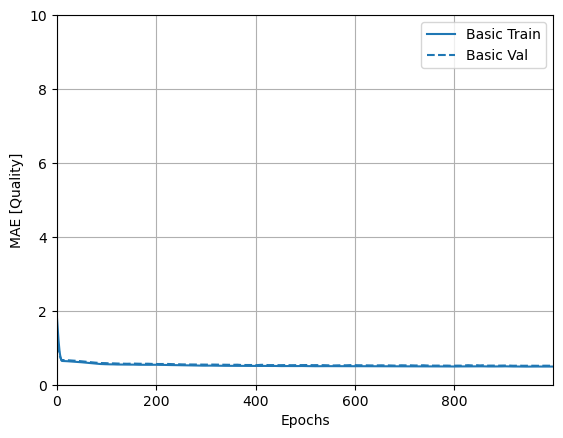

In [127]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Quality]')

In [129]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=1000, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3827,  mae:0.4888,  mse:0.3828,  val_loss:0.4621,  val_mae:0.5083,  val_mse:0.4621,  
........................................

In [130]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [Quality]')

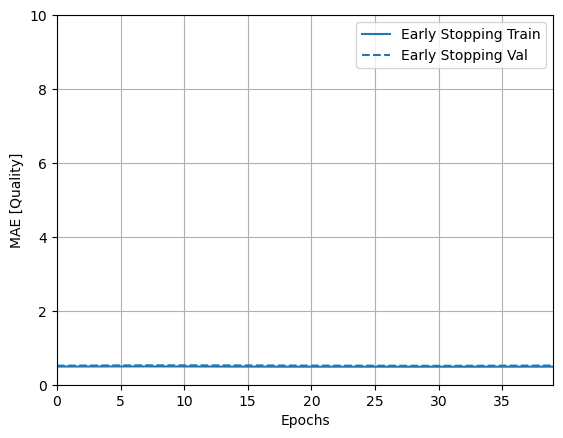

In [131]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [Quality]')

In [132]:
#Evaluate model
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

10/10 - 0s - 5ms/step - loss: 0.4572 - mae: 0.5089 - mse: 0.4572
Testing set Mean Abs Error:  0.51 


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


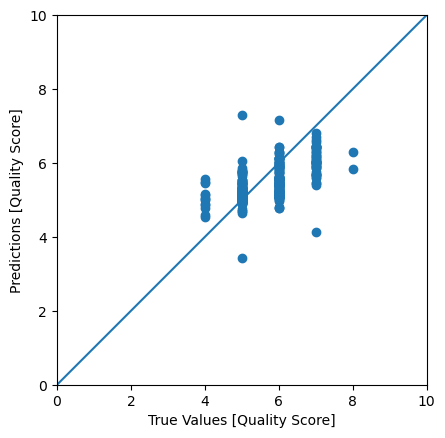

In [133]:
#Use above model to predict wine quality of test data
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Quality Score]')
plt.ylabel('Predictions [Quality Score]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

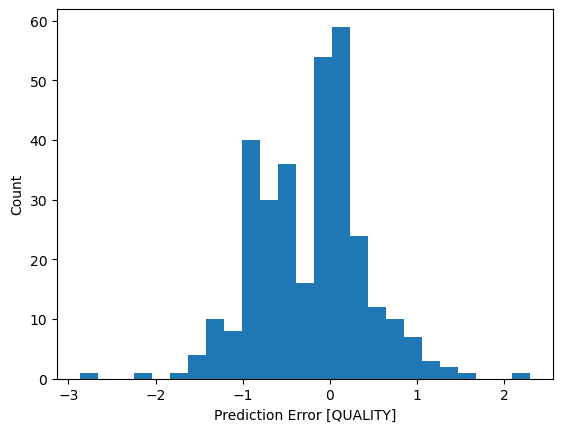

In [135]:
# Evaluate error in the predictions
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [QUALITY]")
_ = plt.ylabel("Count")